In [1]:
setwd('/import/liujing/data/my')

In [2]:
load('../expr.rda')

In [3]:
library(dplyr)

Warning message:
"package 'dplyr' was built under R version 4.2.3"

Attaching package: 'dplyr'


The following objects are masked from 'package:stats':

    filter, lag


The following objects are masked from 'package:base':

    intersect, setdiff, setequal, union




In [4]:
colnames(expr) = gsub('-','.',colnames(expr))

In [19]:
# expr = log2(expr+1)
# expr = expr %>%  as.matrix() 

# expr[is.nan(expr)] = 0

In [37]:
head(expr,2)

,MSLN,HBE1,OTOF,EGR1,HIST1H3F,SAMD14,IGF2,LRP1,PVRL2,GP1BA,...,ZNF268,ZNF141,ZNF441,PPP4R4,DYNLT3,ZDBF2,RPS20,ETAA1,HIST1H2BM,ZNF721
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,...,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CI10_M1,0.001604972,0.13897265,0.6439801,0.4818834,3.334643,0.1074810,0.01531470,6.989592,0.8880691,0.5674804,...,3.797805,12.710151,6.700506,0.2433729,7.730019,1.555564,167.52943,8.471657,10.420602,8.706591
CI11_M1,0.001604972,0.06789091,0.1319284,0.3343645,2.322905,0.4015254,0.08084769,8.119331,0.7771147,2.6697039,...,1.390438,5.253768,2.643442,0.1660712,3.472727,0.799147,84.14582,4.166570,3.172594,1.990680


In [38]:
Type

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [75] 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
[112] 0 0 0 0 0 0 0 0

In [39]:
x = as.matrix(expr)
y = Type

In [8]:
library(lars) 
library(glmnet) 

Warning message:
"package 'lars' was built under R version 4.2.3"
Loaded lars 1.3


Warning message:
"package 'glmnet' was built under R version 4.2.3"
Loading required package: Matrix

Warning message:
"package 'Matrix' was built under R version 4.2.3"
Loaded glmnet 4.1-8



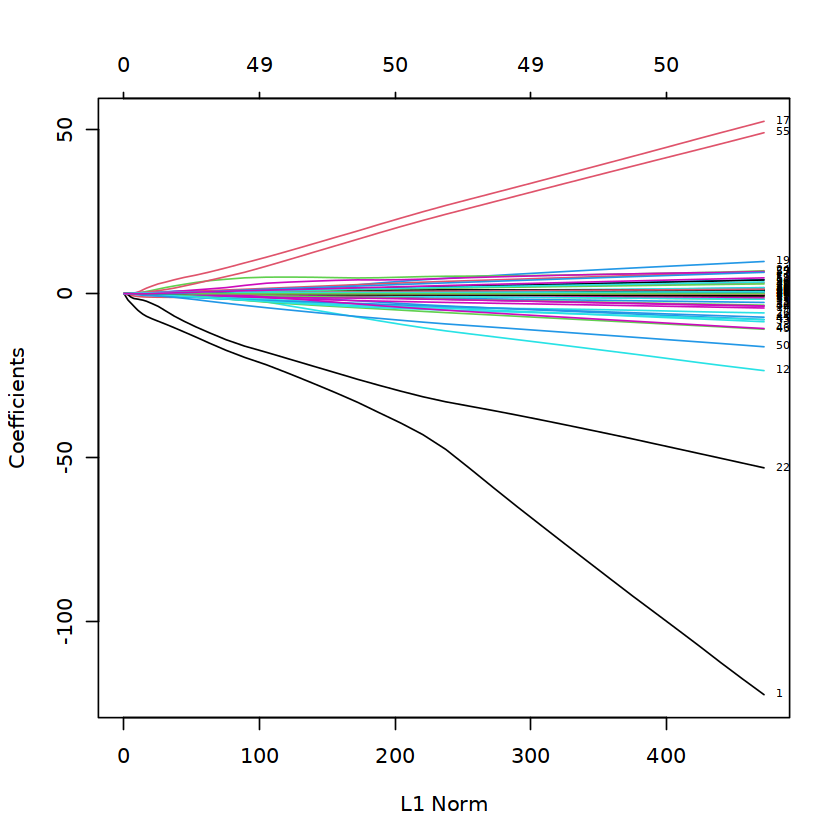

In [9]:

#用基因的表达情况预测生死
model_lasso <- glmnet(x, y, family="binomial", nlambda=50, alpha=1)#拉手回归模型
plot(model_lasso, xvar = "norm", label = TRUE)

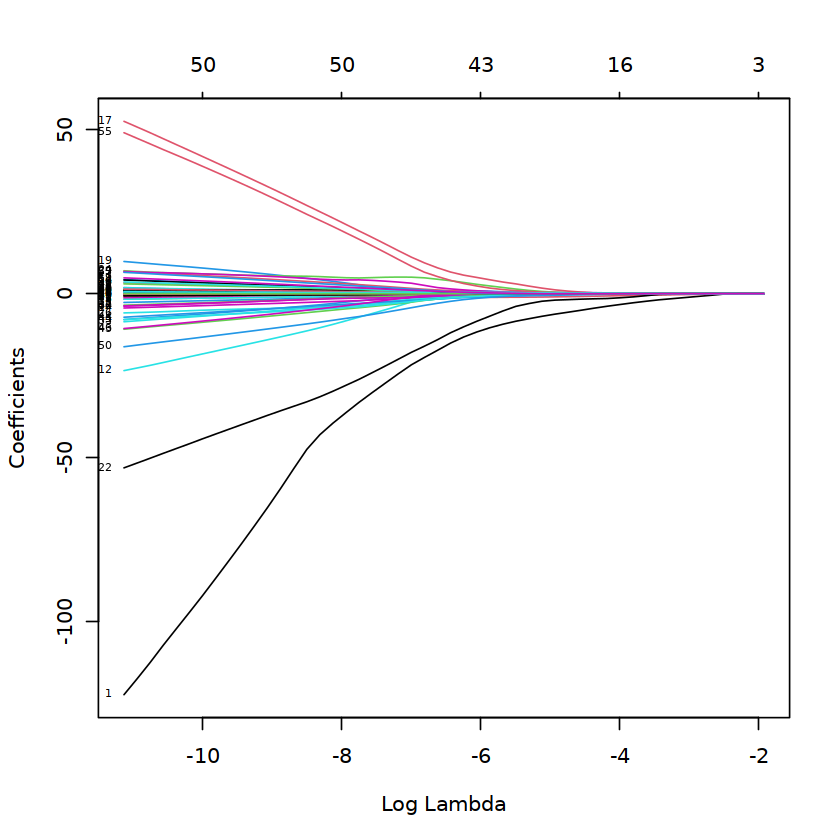

In [10]:
plot(model_lasso, xvar="lambda", label=TRUE)

In [11]:
cv_fit <- cv.glmnet(x=as.matrix(x), y=y, alpha = 1, nlambda = 100)

[1] 0.07595507 0.10040814

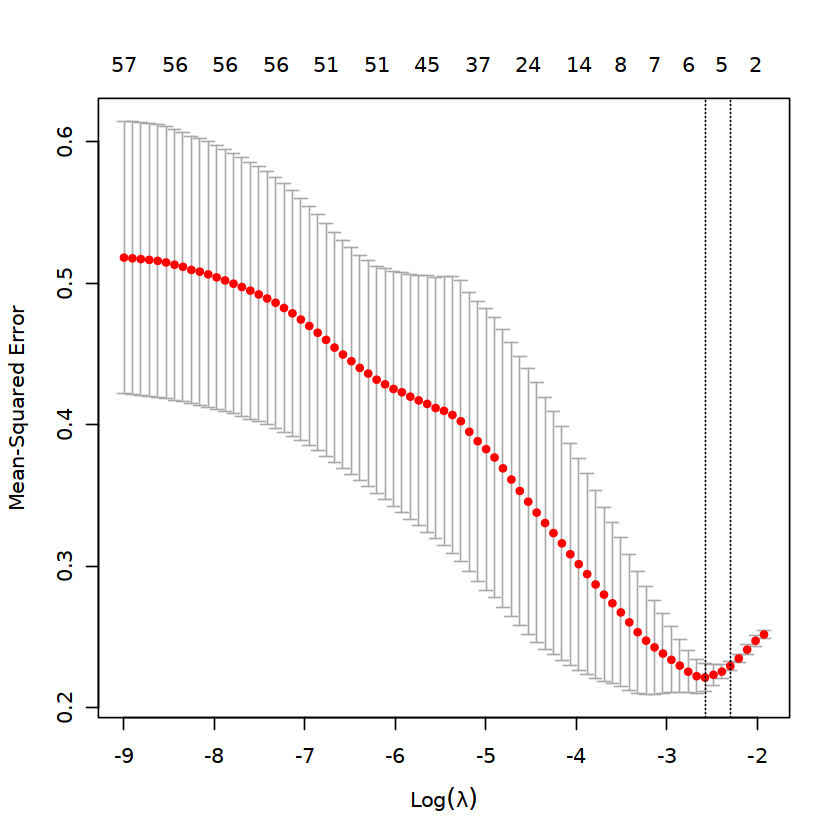

In [12]:
plot(cv_fit)
# 两条虚线分别指示了两个特殊的λ值:
c(cv_fit$lambda.min,cv_fit$lambda.1se) 

In [21]:
model_lasso <- glmnet(x=as.matrix(x), y=y, alpha = 1, lambda=cv_fit$lambda.min)

In [22]:

gene_1se <- rownames(model_lasso$beta)[as.numeric(model_lasso$beta)!=0]

In [23]:
gene_1se = gsub('[.]',' ',gene_1se)

In [24]:
gene_1se

[1] "MSLN"      "HBE1"      "LRP1"      "CDKN1A"    "CEACAM1"   "HIST1H2BM"

In [ ]:
# library(randomForest)
# options(repr.plot.width = 6)
# set.seed(111)
# #  set.seed(111)
# rf = randomForest(as.factor(y)~.,data = x,ntree =1000,important=TRUE,proximity=TRUE)
# plot(rf)
# pdf('forest.pdf',height = 6,width = 6)
# plot(rf)
# dev.off()
# trees = which.min(rf$err.rate[,1])
# rf = randomForest(as.factor(y)~.,data = x,ntree =trees,important=TRUE,proximity=TRUE)
# importance = importance(rf)
# pdf('forest2.pdf',height = 6,width = 4)
# varImpPlot(rf,main = '')
# dev.off()
# options(repr.plot.width = 4)
# varImpPlot(rf,main = '')
# rfGenes=importance[order(importance[, "MeanDecreaseGini"], decreasing  = TRUE),] #重要性评分大于2的基因
# rfGenes
# rfGenes=names(rfGenes[rfGenes>30]) 
# write.table(rfGenes,file="rfGenes.txt",sep="\t",quote=F,col.names=F,row.names=F) #输出表达量
# sigExp=expr[rfGenes,]
# write.table(data.frame(ID=rownames(sigExp),sigExp),file="rfGeneExp.txt",sep="\t",quote=F,col.names=T,row.names=F) 

### svm

In [40]:
library(tidyverse)
library(glmnet)
library(VennDiagram)
library(e1071)
library(caret)
library(randomForest)

In [26]:
# y=as.numeric(as.factor(Type))

In [41]:
library(future)
plan("multisession",workers=30)

In [42]:
set.seed(1)
rfeControl = rfeControl(functions = caretFuncs,
                        method = "cv", # 默认自助法重采样 boot
                        saveDetails = T, # 保存预测值和变量重要性
                        number = 5, # 重抽样次数
                        allowParallel = T # 允许多线程，用这个之前你要先准备好多线程！
                        )

In [43]:
Profile=rfe(x=x,y=y,sizes = c(1:10),
    rfeControl =  rfeControl,
    methods="svmRadial")

Warning message in train.default(x, y, ...):
"You are trying to do regression and your outcome only has two possible values Are you trying to do classification? If so, use a 2 level factor as your outcome column."
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 2 unique complexity parameters in default grid. Truncating the grid to 2 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

note: only 1 unique complexity parameters in default grid. Truncating the grid to 1 .



Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(x, y, mtry = param$mtry, ...):
"The response has five or fewer unique values.  Are you sure you want to do regression?"
Warning message in randomForest.default(

In [49]:
pdf(file="SVM-RFE.pdf", width=6, height=5.5)
par(las=1)
x= Profile$results$Variables 
y =Profile$results$RMSE
plot(x, y, xlab="Variables", ylab="RMSE (Cross-Validation)", col="darkgreen") 
lines(x, y, col="darkgreen")
wmin=which.min(y) 
wmin.x=x[wmin] 
wmin.y=y[wmin]
points(wmin.x, wmin.y, col="blue", pch=16)
text(wmin.x, wmin.y, paste0('N=', wmin.x), pos=2, col=2)
dev.off()

png 
  2

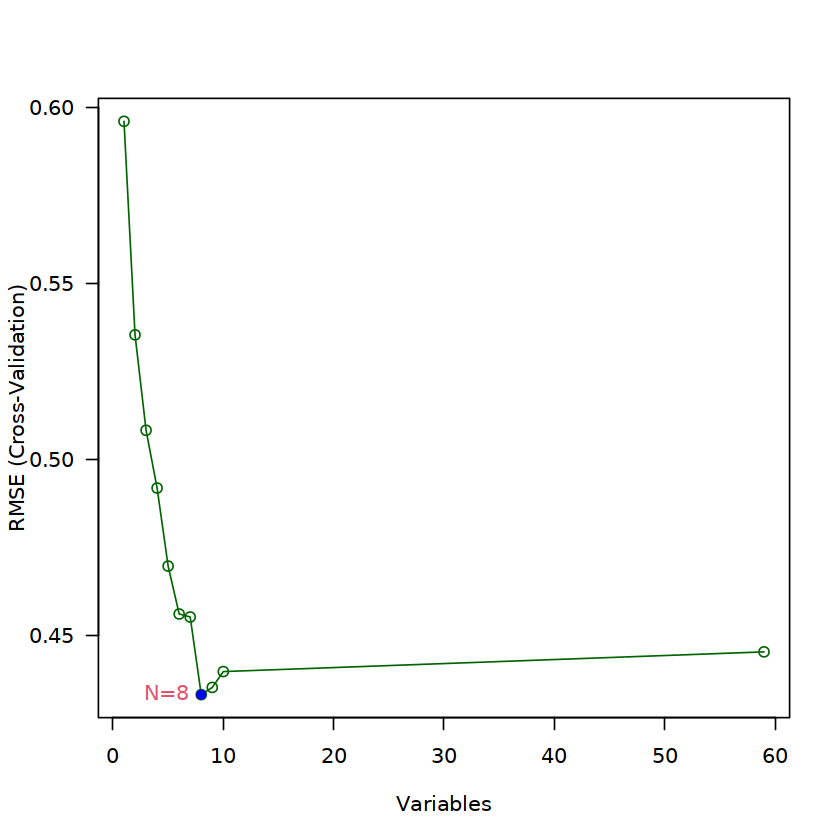

In [50]:
par(las=1)
x= Profile$results$Variables 
y =Profile$results$RMSE
plot(x, y, xlab="Variables", ylab="RMSE (Cross-Validation)", col="darkgreen") 
lines(x, y, col="darkgreen")
wmin=which.min(y) 
wmin.x=x[wmin] 
wmin.y=y[wmin]
points(wmin.x, wmin.y, col="blue", pch=16)
text(wmin.x, wmin.y, paste0('N=', wmin.x), pos=2, col=2)

In [51]:
#输出
featureGenes = Profile$optVariables
write.table(file="SVM-RFE.gene.txt",featureGenes,sep="\t",quote=F,row.names=F,col.names=F) #表达矩阵 

In [82]:
featureGenes

[1] "HIST1H2BM" "HIST1H3F"  "CEACAM1"   "TGFB1I1"   "ZNF300"    "CDKN1A"   
[7] "RCN3"      "HBE1"

### Boruta

In [54]:
library(Boruta)

In [55]:
x = as.matrix(expr)
y = Type

In [56]:
set.seed(1)
boruta <- Boruta(x=x, y=y, pValue=0.05, mcAdj=T, 
       maxRuns=300)

In [57]:
boruta

Boruta performed 299 iterations in 17.9025 secs.
 12 attributes confirmed important: CDKN1A, CEACAM1, GP1BA, HBE1,
HIST1H2BM and 7 more;
 45 attributes confirmed unimportant: ANKRD49, C6orf25, COMMD6, DYNLT3,
EGFL7 and 40 more;
 2 tentative attributes left: PTGS1, STAB1;

In [58]:
table(boruta$finalDecision)


Tentative Confirmed  Rejected 
        2        12        45 

In [59]:
boruta$finalDecision

MSLN      HBE1      OTOF      EGR1  HIST1H3F    SAMD14      IGF2      LRP1 
Confirmed Confirmed  Rejected  Rejected Confirmed Confirmed  Rejected Confirmed 
    PVRL2     GP1BA    GAS2L1   TGFB1I1   C6orf25    CDKN1A       PF4     PPDPF 
 Rejected Confirmed  Rejected  Rejected  Rejected Confirmed  Rejected Confirmed 
    WASF3      NRGN     EGFL7      RIN1      ESAM    PKMYT1     PTGS1     LAMA5 
 Rejected  Rejected  Rejected  Rejected  Rejected  Rejected Tentative  Rejected 
     RCN3     MMP14     STAB1     TTYH3     TOR4A       GAA   SLC19A1    FERMT3 
Confirmed  Rejected Tentative  Rejected  Rejected  Rejected  Rejected  Rejected 
 TMEM150B   FAM129B    PLXNB2      TLN1    COMMD6    MRPL32     MRPL3      SVIP 
 Rejected  Rejected  Rejected  Rejected  Rejected  Rejected  Rejected  Rejected 
   ZNF708      RBAK     WDR89     ZNF91    ZNF300    ZNF260   ANKRD49   CEACAM1 
 Rejected  Rejected  Rejected  Rejected Confirmed  Rejected  Rejected Confirmed 
   ZNF737    ZNF268    ZNF141    ZNF441    PPP4R4    DYNLT3     ZDBF2     RPS20 
 Rejected  Rejected  Rejected  Rejected  Rejected  Rejected  Rejected  Rejected 
    ETAA1 HIST1H2BM    ZNF721 
 Rejected Confirmed  Rejected 
Levels: Tentative Confirmed Rejected

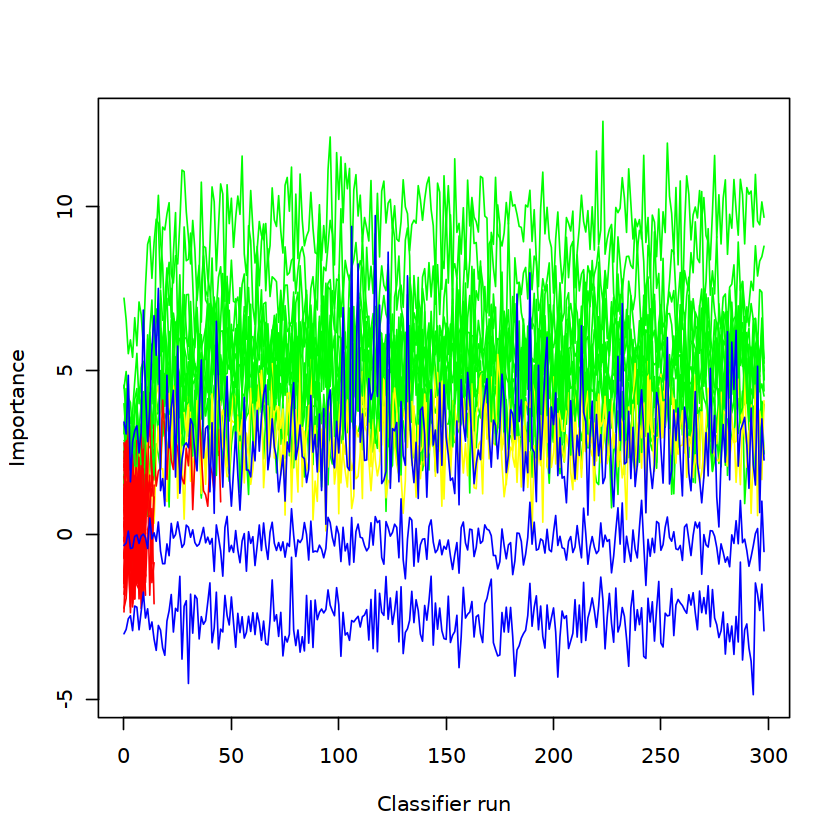

In [60]:
Boruta::plotImpHistory(boruta)

In [61]:
library(dplyr)
boruta.imp <- function(x){
  imp <- reshape2::melt(x$ImpHistory, na.rm=T)[,-1]
  colnames(imp) <- c("Variable","Importance")
  imp <- imp[is.finite(imp$Importance),]

  variableGrp <- data.frame(Variable=names(x$finalDecision), 
                            finalDecision=x$finalDecision)

  showGrp <- data.frame(Variable=c("shadowMax", "shadowMean", "shadowMin"),
                        finalDecision=c("shadowMax", "shadowMean", "shadowMin"))

  variableGrp <- rbind(variableGrp, showGrp)

  boruta.variable.imp <- merge(imp, variableGrp, all.x=T)

  sortedVariable <- boruta.variable.imp %>% group_by(Variable) %>% 
    summarise(median=median(Importance)) %>% arrange(median)
  sortedVariable <- as.vector(sortedVariable$Variable)


  boruta.variable.imp$Variable <- factor(boruta.variable.imp$Variable, levels=sortedVariable)

  invisible(boruta.variable.imp)
}
boruta.variable.imp <- boruta.imp(boruta)


Welcome to YSX package which is a collection of useful scripts.
This package does not require you install all depended packages, since one may not need all functions in this package.
However, when there is a message implying some functions are missing,please install these packages manually.
Or more specially, check Plot.Rmd in vignettes first.




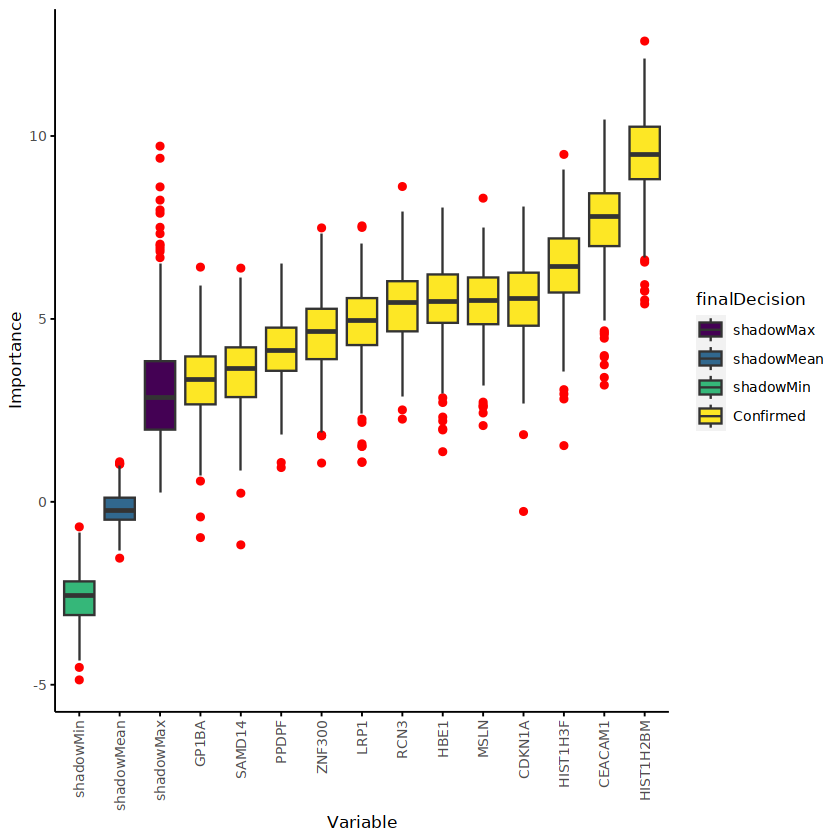

In [62]:
library(YSX)

sp_boxplot(boruta.variable.imp, melted=T, xvariable = "Variable", yvariable = "Importance",
           legend_variable = "finalDecision", legend_variable_order = c("shadowMax", "shadowMean", "shadowMin", "Confirmed"),
           xtics_angle = 90)

In [63]:
Group = data.frame(Group =  c(rep('CI',43),rep('H',42),rep('CI',16),rep('H',18)))

In [64]:
expr3 = cbind(Group,expr)

In [65]:
set.seed(157)  
index <-  which( (1:nrow(expr3))%%3 == 0 )
train <- expr3[-index,]
test <- expr3[index,]

In [66]:
table(test$Group)


CI  H 
19 20 

In [67]:
library("xgboost")
library("Matrix")
train_matrix <- sparse.model.matrix(Group ~ .-1, data = train)
test_matrix <- sparse.model.matrix(Group ~ .-1, data = test)
all_matrix <- sparse.model.matrix(Group ~ .-1, data = expr3)


Attaching package: 'xgboost'


The following object is masked from 'package:dplyr':

    slice




In [68]:
train_label <- as.numeric(train$Group == 'CI')
test_label <-  as.numeric(test$Group == 'CI')
all_label <-  as.numeric(expr3$Group == 'CI')

In [69]:
all_label

[1] 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 [38] 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 [75] 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
[112] 0 0 0 0 0 0 0 0

In [70]:
train_fin <- list(data=train_matrix,label=train_label) 
test_fin <- list(data=test_matrix,label=test_label) 
all_fin <- list(data=all_matrix,label=all_label) 

dtrain <- xgb.DMatrix(data = train_fin$data, label = train_fin$label) 
dtest <- xgb.DMatrix(data = test_fin$data, label = test_fin$label)
dall <- xgb.DMatrix(data = all_fin$data, label = all_fin$label)

In [71]:
xgb <- xgboost(data = dall,max_depth=6, eta=0.5,  
  objective='binary:logistic', nround=25)

[1]	train-logloss:0.459449 
[2]	train-logloss:0.325779 
[3]	train-logloss:0.248934 
[4]	train-logloss:0.188875 
[5]	train-logloss:0.149395 
[6]	train-logloss:0.126922 
[7]	train-logloss:0.105484 
[8]	train-logloss:0.092378 
[9]	train-logloss:0.083171 
[10]	train-logloss:0.073914 
[11]	train-logloss:0.069532 
[12]	train-logloss:0.064200 
[13]	train-logloss:0.060193 
[14]	train-logloss:0.056029 
[15]	train-logloss:0.052218 
[16]	train-logloss:0.049370 
[17]	train-logloss:0.047142 
[18]	train-logloss:0.044809 
[19]	train-logloss:0.042796 
[20]	train-logloss:0.041475 
[21]	train-logloss:0.040010 
[22]	train-logloss:0.038963 
[23]	train-logloss:0.037912 
[24]	train-logloss:0.037247 
[25]	train-logloss:0.036449 


In [72]:
xgb

##### xgb.Booster
raw: 28.7 Kb 
call:
  xgb.train(params = params, data = dtrain, nrounds = nrounds, 
    watchlist = watchlist, verbose = verbose, print_every_n = print_every_n, 
    early_stopping_rounds = early_stopping_rounds, maximize = maximize, 
    save_period = save_period, save_name = save_name, xgb_model = xgb_model, 
    callbacks = callbacks, max_depth = 6, eta = 0.5, objective = "binary:logistic")
params (as set within xgb.train):
  max_depth = "6", eta = "0.5", objective = "binary:logistic", validate_parameters = "TRUE"
xgb.attributes:
  niter
callbacks:
  cb.print.evaluation(period = print_every_n)
  cb.evaluation.log()
# of features: 59 
niter: 25
nfeatures : 59 
evaluation_log:
    iter train_logloss
       1    0.45944947
       2    0.32577930
---                   
      24    0.03724724
      25    0.03644921

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
HIST1H2BM,0.13022435,0.10158080,0.06779661
HIST1H3F,0.11597844,0.08850469,0.06779661
CEACAM1,0.07351649,0.05872656,0.05084746
CDKN1A,0.07094302,0.06821581,0.04237288
MSLN,0.06303528,0.05716553,0.05084746
RCN3,0.06115768,0.05281875,0.04237288


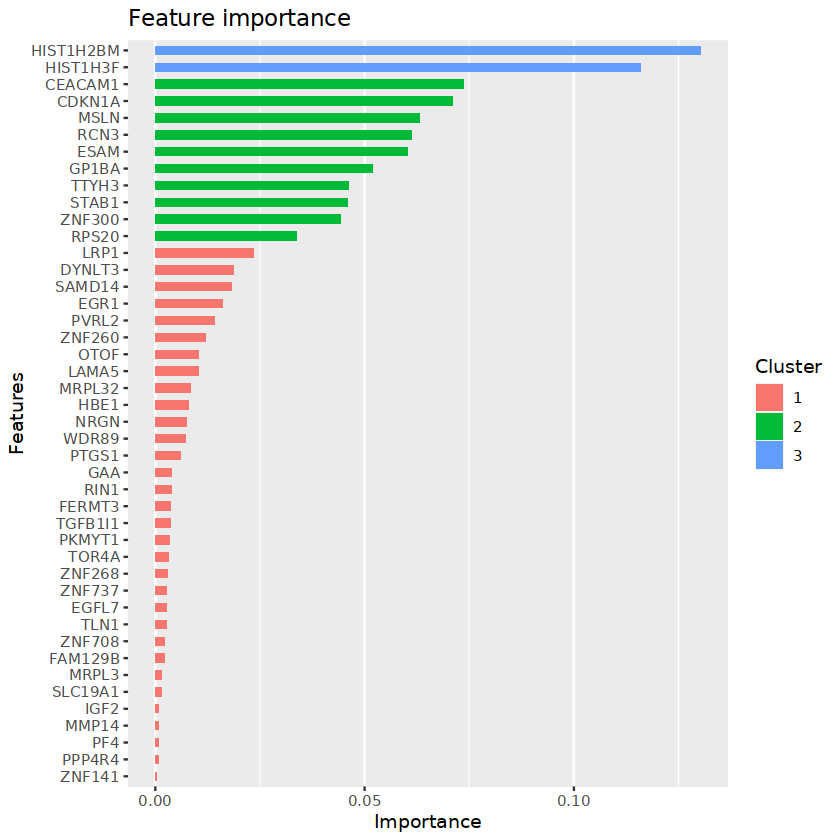

In [73]:
importance <- xgb.importance(all_matrix@Dimnames[[2]], model = xgb)  
head(importance)
xgb.ggplot.importance(importance)

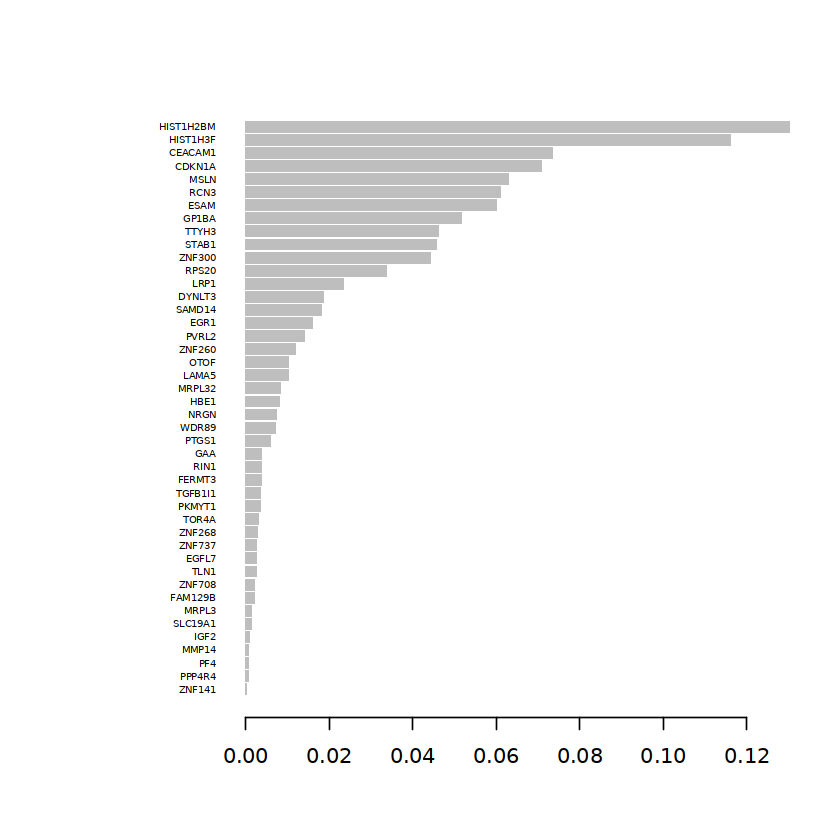

In [74]:
xgb.plot.importance(importance)

### 韦恩图

In [83]:
RF.gene = gene_1se
SVF.RFE.gene = featureGenes
XGBoost.gene = importance$Feature

In [84]:
boruta.variable.imp2 = boruta.variable.imp %>% dplyr::filter(finalDecision %in% c('Confirmed')) %>% dplyr::select(Variable) %>% unique()

In [85]:
Boruta.gene = as.vector(boruta.variable.imp2$Variable)

In [86]:
list1 = list(Boruta.gene,SVF.RFE.gene, RF.gene,XGBoost.gene) #

In [87]:
data =  as.data.frame (do.call (cbind, list1))

Warning message in (function (..., deparse.level = 1) :
"number of rows of result is not a multiple of vector length (arg 1)"


In [88]:

library(venn)
        library(VennDiagram)
        color=c( "#3C5488B2","#00A087B2", 
             "#F39B7FB2","#91D1C2B2", 
             "#8491B4B2", "#DC0000B2", 
             "#7E6148B2","yellow", 
             "darkolivegreen1", "lightskyblue", 
             "darkgreen", "deeppink", "khaki2", 
             "firebrick", "brown1", "darkorange1", 
             "cyan1", "royalblue4", "darksalmon", 
             "darkgoldenrod1", "darkseagreen", "darkorchid")

    if (ncol(data) == 2){
        sample_list <- list(Boruta.gene = data[,1], XGBoost.gene = data[,2])
    }else if(ncol(data) == 3){
        sample_list <- list(RF.gene = data[,1], Boruta.gene = data[,2], XGBoost.gene = data[,3])
    }else if(ncol(data) == 4){
        sample_list <- list(RF.gene = data[,1], SVF.RFE.gene = data[,2], Boruta.gene = data[,3], XGBoost.gene = data[,4])
    }else{
        sample_list <- list(c1 = data[,1], c2 = data[,2], c3 = data[,3], c4 = data[,4], c5 = data[,5])
    }
    
    q <- venn.diagram(sample_list,filename = NULL,
             fill = color[1:(length(sample_list))],
             alpha = 0.50, cat.col = rep('black', ncol(data)), 
             col = 'black', cex = 1, fontfamily = 'serif', cat.cex = 1, cat.fontfamily = 'serif', margin = 0.2
                             )
    pdf(paste0('./',"venn.pdf"))
    grid.draw(q)
    dev.off()

Warning message:
"package 'venn' was built under R version 4.2.3"


png 
  2

In [89]:
options(repr.plot.width = 6)

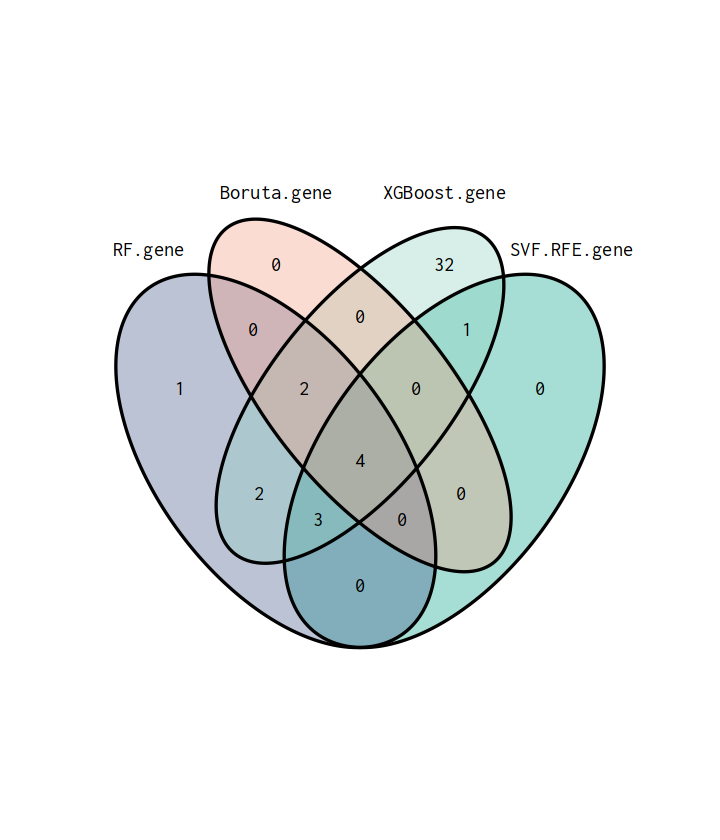

In [90]:
grid.draw(q)

In [91]:
model.gene = intersect(intersect(intersect(RF.gene,XGBoost.gene),Boruta.gene),SVF.RFE.gene)#

In [92]:
model.gene

[1] "HBE1"      "CDKN1A"    "CEACAM1"   "HIST1H2BM"

In [93]:
set.seed(1234)
expr3 = cbind(Group,expr)

In [94]:
expr3[expr3$Group =='CI',]$Group<-1

In [95]:
expr3[expr3$Group =='H',]$Group<-0
expr3$Group = as.numeric(expr3$Group)

In [96]:
expr4 = expr3 %>% dplyr::select(c(Group,model.gene))

Warning message:
"Using an external vector in selections was deprecated in tidyselect 1.1.0.
i Please use `all_of()` or `any_of()` instead.
  # Was:
  data %>% select(model.gene)

  # Now:
  data %>% select(all_of(model.gene))

See <https://tidyselect.r-lib.org/reference/faq-external-vector.html>."


In [97]:
dim(expr4)

[1] 119   5

In [98]:
head(expr4,4)

,Group,HBE1,CDKN1A,CEACAM1,HIST1H2BM
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CI10_M1,1,0.13897265,5.173722,6.247454,10.420602
CI11_M1,1,0.06789091,5.430353,14.772961,3.172594
CI12_M1,1,0.02127094,5.624813,9.417403,26.555932
CI13_M1,1,0.08047129,9.627065,15.692822,12.907428


In [99]:
library(caret)
library(ggplot2)

### 这里使用48个基因先看看情况



In [100]:
for (i in model.gene){
    res<-pROC::roc(Group~expr4[,i],data=expr4,aur=TRUE,
         ci=TRUE, # 显示95%CI
         #percent=TRUE, # 是否需要以百分比显示
         smooth=FALSE,# 是否平滑曲线
         levels=c(0,1),direction="<" #设置分组方向
         )
    if (res$auc > 0.5){
        print(paste0(i,' ',res$auc))
        p = pROC::ggroc(res, color ="red",legacy.axes = TRUE)+
  geom_segment(aes(x = 0, xend = 1, y = 0, yend = 1), color="darkgrey", linetype=4)+
  theme_bw() + # 设置背景
  ggtitle(paste0(i," ROC Curve"))+
  theme(plot.title = element_text(hjust = 0.5,size = 16),
        axis.text=element_text(size=12,colour = "black"),
        axis.title.x = element_text(size = 14),
        axis.title.y = element_text(size = 14))
p+annotate("text",x=0.75,y=0.25,label=paste("AUC = ", round(res$auc,3)))+
  annotate("text",x=0.75,y=0.20,label=paste("95%CI: ", round(res$ci[1],3),'-',round(res$ci[3],3)))
    ggsave(file = paste0(i,'.ROC.pdf'))
}else{
        
}

    
    }

[1] "CEACAM1 0.665254237288136"


Saving 6.67 x 6.67 in image


[1] "HIST1H2BM 0.659322033898305"


Saving 6.67 x 6.67 in image


### 批量单因素逻辑回归

In [72]:
#expr4 = expr3

In [101]:
#结果合并需要的包
library(plyr)
#可进行logistic回归的包
library(rms)#可实现逻辑回归模型（lrm）
library(epiDisplay)#快速输出OR、95%CI、P
#library(gtsummary)#精美三线表（但，95%CI有误）

------------------------------------------------------------------------------

You have loaded plyr after dplyr - this is likely to cause problems.
If you need functions from both plyr and dplyr, please load plyr first, then dplyr:
library(plyr); library(dplyr)

------------------------------------------------------------------------------


Attaching package: 'plyr'


The following object is masked from 'package:purrr':

    compact


The following objects are masked from 'package:dplyr':

    arrange, count, desc, failwith, id, mutate, rename, summarise,
    summarize


Loading required package: Hmisc

Warning message:
"package 'Hmisc' was built under R version 4.2.3"

Attaching package: 'Hmisc'


The following objects are masked from 'package:plyr':

    is.discrete, summarize


The following object is masked from 'package:e1071':

    impute


The following objects are masked from 'package:dplyr':

    src, summarize


The following objects are masked from 'package:base':

    for

In [102]:
varsU<-names(expr4[,2:dim(expr4)[2]])

In [103]:
Result<-c()
for (i in 1:length(varsU)){
  fit<-glm(substitute(Group~x,list(x=as.name(varsU[i]))),data=expr4,family=binomial())
  fitSum<-summary(fit)
  result1<-c()
  result1<-rbind(result1,fitSum$coef)
  OR<-exp(fitSum$coef[,'Estimate'])
  result1<-data.frame(cbind(result1,cbind(OR,exp(confint(fit)))))
  result1$Characteristics<-varsU[i]   #添加变量名
  Result<-rbind(Result,result1[-1,])#[-1,],删除常数项
}

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...

Waiting for profiling to be done...



In [104]:
Result

,Estimate,Std..Error,z.value,Pr...z..,OR,X2.5..,X97.5..,Characteristics
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
HBE1,-1.9570497,1.00239558,-1.952373,0.050893980,0.1412746,0.01296534,0.6261262,HBE1
CDKN1A,-0.1655846,0.05500175,-3.010533,0.002607900,0.8473982,0.75505893,0.9382970,CDKN1A
CEACAM1,0.1846884,0.06094743,3.030291,0.002443183,1.2028436,1.07694194,1.3693359,CEACAM1
HIST1H2BM,0.1344959,0.04537201,2.964292,0.003033801,1.1439600,1.05750187,1.2612607,HIST1H2BM


In [105]:
Uni_log<-data.frame(Result[,c(1,4:8)]) #提取"P","OR","CIlower","CIupper"和变量名

colnames(Uni_log)[2:5]<-c("P","OR","CIlower","CIupper")#变量重命名

ExtractVar<-unique(Uni_log$Characteristics[Uni_log$"P"<0.01]) 


In [106]:
tzgene = Uni_log %>% dplyr::filter(P < 0.01) %>% rownames()

In [107]:
Uni_log[tzgene,]

,Estimate,P,OR,CIlower,CIupper,Characteristics
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
CDKN1A,-0.1655846,0.002607900,0.8473982,0.7550589,0.938297,CDKN1A
CEACAM1,0.1846884,0.002443183,1.2028436,1.0769419,1.369336,CEACAM1
HIST1H2BM,0.1344959,0.003033801,1.1439600,1.0575019,1.261261,HIST1H2BM


### 多因素分析

In [80]:
tzgene

[1] "RAB7A"     "CMTM1"     "PLP2"      "RPL28"     "NEK2"      "TNFSF14"  
 [7] "SGOL1"     "SP110"     "SAP130"    "CEP55"     "TPM3"      "CCNA2"    
[13] "MARCKS"    "U2AF1L4"   "S100A11"   "ZNF608"    "HIST2H2BE"

In [81]:
#tzgene1 = tzgene[-5]

In [82]:
data = expr4[,c('Group',tzgene)]
data$Group = factor(data$Group,levels = c(1,0))

In [83]:
fit.reduce<-glm(Group~.,data=data,family=binomial())
summary(fit.reduce)

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Call:
glm(formula = Group ~ ., family = binomial(), data = data)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.2443  -0.1863   0.0108   0.3024   1.9327  

Coefficients:
              Estimate Std. Error z value Pr(>|z|)    
(Intercept)  27.008063   6.176560   4.373 1.23e-05 ***
RAB7A        -0.005812   0.056213  -0.103   0.9177    
CMTM1        -0.055865   0.062043  -0.900   0.3679    
PLP2         -0.021867   0.042800  -0.511   0.6094    
RPL28        -0.007798   0.018516  -0.421   0.6736    
NEK2        -14.590263   7.151195  -2.040   0.0413 *  
TNFSF14      -0.216985   0.114823  -1.890   0.0588 .  
SGOL1        -6.029320   2.468900  -2.442   0.0146 *  
SP110         0.037766   0.052515   0.719   0.4721    
SAP130       -0.620139   0.311535  -1.991   0.0465 *  
CEP55        -3.111144   3.209897  -0.969   0.3324    
TPM3          0.047909   0.074252   0.645   0.5188    
CCNA2        -2.373919   1.154988  -2.055   0.0398 *  
MARCKS       -0.171599   0.089823  

In [84]:
logit.step <- step(fit.reduce,direction='both')
summary(logit.step)

Start:  AIC=94.53
Group ~ RAB7A + CMTM1 + PLP2 + RPL28 + NEK2 + TNFSF14 + SGOL1 + 
    SP110 + SAP130 + CEP55 + TPM3 + CCNA2 + MARCKS + U2AF1L4 + 
    S100A11 + ZNF608 + HIST2H2BE



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

            Df Deviance    AIC
- RAB7A      1   58.540 92.540
- RPL28      1   58.706 92.706
- S100A11    1   58.714 92.714
- PLP2       1   58.792 92.792
- TPM3       1   58.947 92.947
- SP110      1   59.071 93.071
- HIST2H2BE  1   59.093 93.093
- CMTM1      1   59.353 93.353
- CEP55      1   59.492 93.492
- U2AF1L4    1   59.894 93.894
<none>           58.529 94.529
- ZNF608     1   61.322 95.322
- TNFSF14    1   62.734 96.734
- MARCKS     1   62.909 96.909
- SAP130     1   63.086 97.086
- NEK2       1   63.452 97.452
- CCNA2      1   64.143 98.143
- SGOL1      1   65.398 99.398


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Step:  AIC=92.54
Group ~ CMTM1 + PLP2 + RPL28 + NEK2 + TNFSF14 + SGOL1 + SP110 + 
    SAP130 + CEP55 + TPM3 + CCNA2 + MARCKS + U2AF1L4 + S100A11 + 
    ZNF608 + HIST2H2BE



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

            Df Deviance    AIC
- S100A11    1   58.717 90.717
- RPL28      1   58.721 90.721
- PLP2       1   58.984 90.984
- TPM3       1   59.001 91.001
- SP110      1   59.075 91.075
- HIST2H2BE  1   59.147 91.147
- CMTM1      1   59.359 91.359
- CEP55      1   59.543 91.543
- U2AF1L4    1   59.928 91.928
<none>           58.540 92.540
- ZNF608     1   61.428 93.428
+ RAB7A      1   58.529 94.529
- TNFSF14    1   62.884 94.884
- MARCKS     1   63.017 95.017
- SAP130     1   63.437 95.437
- NEK2       1   63.480 95.480
- CCNA2      1   64.249 96.249
- SGOL1      1   65.424 97.424


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Step:  AIC=90.72
Group ~ CMTM1 + PLP2 + RPL28 + NEK2 + TNFSF14 + SGOL1 + SP110 + 
    SAP130 + CEP55 + TPM3 + CCNA2 + MARCKS + U2AF1L4 + ZNF608 + 
    HIST2H2BE



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

            Df Deviance    AIC
- RPL28      1   58.819 88.819
- PLP2       1   58.997 88.997
- TPM3       1   59.135 89.135
- HIST2H2BE  1   59.238 89.238
- CMTM1      1   59.390 89.390
- SP110      1   59.406 89.406
- CEP55      1   59.742 89.742
- U2AF1L4    1   60.488 90.488
<none>           58.717 90.717
- ZNF608     1   61.651 91.651
+ S100A11    1   58.540 92.540
+ RAB7A      1   58.714 92.714
- MARCKS     1   63.059 93.059
- TNFSF14    1   63.187 93.187
- SAP130     1   63.454 93.454
- NEK2       1   63.531 93.531
- CCNA2      1   65.552 95.552
- SGOL1      1   65.787 95.787


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Step:  AIC=88.82
Group ~ CMTM1 + PLP2 + NEK2 + TNFSF14 + SGOL1 + SP110 + SAP130 + 
    CEP55 + TPM3 + CCNA2 + MARCKS + U2AF1L4 + ZNF608 + HIST2H2BE



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

            Df Deviance    AIC
- PLP2       1   59.248 87.248
- TPM3       1   59.283 87.283
- CMTM1      1   59.390 87.390
- SP110      1   59.413 87.413
- HIST2H2BE  1   59.414 87.414
- CEP55      1   59.787 87.787
<none>           58.819 88.819
- U2AF1L4    1   61.360 89.360
- ZNF608     1   61.720 89.720
+ RPL28      1   58.717 90.717
+ S100A11    1   58.721 90.721
+ RAB7A      1   58.786 90.786
- MARCKS     1   63.257 91.257
- NEK2       1   63.802 91.802
- SAP130     1   63.848 91.848
- TNFSF14    1   63.900 91.900
- CCNA2      1   65.660 93.660
- SGOL1      1   65.787 93.787


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Step:  AIC=87.25
Group ~ CMTM1 + NEK2 + TNFSF14 + SGOL1 + SP110 + SAP130 + CEP55 + 
    TPM3 + CCNA2 + MARCKS + U2AF1L4 + ZNF608 + HIST2H2BE



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

            Df Deviance    AIC
- TPM3       1   59.538 85.538
- SP110      1   59.828 85.828
- HIST2H2BE  1   60.024 86.024
- CMTM1      1   60.072 86.072
- CEP55      1   60.158 86.158
<none>           59.248 87.248
- U2AF1L4    1   61.538 87.538
- ZNF608     1   62.045 88.045
+ PLP2       1   58.819 88.819
+ RPL28      1   58.997 88.997
+ RAB7A      1   59.199 89.199
+ S100A11    1   59.241 89.241
- MARCKS     1   63.433 89.433
- NEK2       1   63.860 89.860
- TNFSF14    1   64.136 90.136
- SAP130     1   64.188 90.188
- CCNA2      1   65.661 91.661
- SGOL1      1   66.551 92.551


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Step:  AIC=85.54
Group ~ CMTM1 + NEK2 + TNFSF14 + SGOL1 + SP110 + SAP130 + CEP55 + 
    CCNA2 + MARCKS + U2AF1L4 + ZNF608 + HIST2H2BE



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

            Df Deviance    AIC
- SP110      1   60.126 84.126
- HIST2H2BE  1   60.175 84.175
- CMTM1      1   60.321 84.321
- CEP55      1   60.375 84.375
<none>           59.538 85.538
- U2AF1L4    1   61.821 85.821
- ZNF608     1   62.489 86.489
+ TPM3       1   59.248 87.248
+ RPL28      1   59.274 87.274
+ PLP2       1   59.283 87.283
- MARCKS     1   63.496 87.496
+ RAB7A      1   59.534 87.534
+ S100A11    1   59.537 87.537
- NEK2       1   64.146 88.146
- TNFSF14    1   65.483 89.483
- SAP130     1   65.644 89.644
- CCNA2      1   66.509 90.509
- SGOL1      1   66.944 90.944


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Step:  AIC=84.13
Group ~ CMTM1 + NEK2 + TNFSF14 + SGOL1 + SAP130 + CEP55 + CCNA2 + 
    MARCKS + U2AF1L4 + ZNF608 + HIST2H2BE



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

            Df Deviance    AIC
- CMTM1      1   60.464 82.464
- HIST2H2BE  1   60.768 82.768
- CEP55      1   61.078 83.078
- U2AF1L4    1   61.996 83.996
<none>           60.126 84.126
- ZNF608     1   63.004 85.004
- MARCKS     1   63.511 85.511
+ SP110      1   59.538 85.538
+ TPM3       1   59.828 85.828
+ PLP2       1   59.894 85.894
+ RPL28      1   60.045 86.045
+ S100A11    1   60.103 86.103
+ RAB7A      1   60.123 86.123
- NEK2       1   64.248 86.248
- SAP130     1   65.747 87.747
- CCNA2      1   66.548 88.548
- TNFSF14    1   66.926 88.926
- SGOL1      1   68.080 90.080


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Step:  AIC=82.46
Group ~ NEK2 + TNFSF14 + SGOL1 + SAP130 + CEP55 + CCNA2 + MARCKS + 
    U2AF1L4 + ZNF608 + HIST2H2BE



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"

            Df Deviance    AIC
- CEP55      1   61.502 81.502
- HIST2H2BE  1   61.959 81.959
<none>           60.464 82.464
- U2AF1L4    1   62.643 82.643
- ZNF608     1   63.778 83.778
- MARCKS     1   63.788 83.788
+ PLP2       1   60.100 84.100
+ CMTM1      1   60.126 84.126
+ TPM3       1   60.212 84.212
+ SP110      1   60.321 84.321
- NEK2       1   64.434 84.434
+ RPL28      1   60.443 84.443
+ RAB7A      1   60.443 84.443
+ S100A11    1   60.459 84.459
- SAP130     1   67.916 87.916
- SGOL1      1   68.084 88.084
- CCNA2      1   68.096 88.096
- TNFSF14    1   68.891 88.891


Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"



Step:  AIC=81.5
Group ~ NEK2 + TNFSF14 + SGOL1 + SAP130 + CCNA2 + MARCKS + U2AF1L4 + 
    ZNF608 + HIST2H2BE



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


            Df Deviance    AIC
- HIST2H2BE  1   62.496 80.496
<none>           61.502 81.502
- U2AF1L4    1   63.714 81.714
+ CEP55      1   60.464 82.464
+ CMTM1      1   61.078 83.078
- MARCKS     1   65.117 83.117
+ PLP2       1   61.148 83.148
- ZNF608     1   65.282 83.282
+ SP110      1   61.336 83.336
+ TPM3       1   61.350 83.350
+ RAB7A      1   61.426 83.426
- NEK2       1   65.473 83.473
+ RPL28      1   61.502 83.502
+ S100A11    1   61.502 83.502
- TNFSF14    1   69.081 87.081
- SAP130     1   69.206 87.206
- SGOL1      1   69.524 87.524
- CCNA2      1   72.683 90.683

Step:  AIC=80.5
Group ~ NEK2 + TNFSF14 + SGOL1 + SAP130 + CCNA2 + MARCKS + U2AF1L4 + 
    ZNF608



Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


            Df Deviance    AIC
- U2AF1L4    1   64.420 80.420
<none>           62.496 80.496
+ CMTM1      1   61.372 81.372
+ HIST2H2BE  1   61.502 81.502
+ PLP2       1   61.619 81.619
- NEK2       1   65.737 81.737
+ CEP55      1   61.959 81.959
- ZNF608     1   65.976 81.976
+ RAB7A      1   62.003 82.003
+ S100A11    1   62.246 82.246
+ TPM3       1   62.487 82.487
+ RPL28      1   62.488 82.488
+ SP110      1   62.489 82.489
- MARCKS     1   67.927 83.927
- SGOL1      1   71.426 87.426
- SAP130     1   72.213 88.213
- CCNA2      1   72.889 88.889
- TNFSF14    1   73.778 89.778

Step:  AIC=80.42
Group ~ NEK2 + TNFSF14 + SGOL1 + SAP130 + CCNA2 + MARCKS + ZNF608

            Df Deviance     AIC
<none>           64.420  80.420
+ U2AF1L4    1   62.496  80.496
- NEK2       1   66.771  80.771
+ CMTM1      1   62.983  80.983
- ZNF608     1   67.502  81.502
+ HIST2H2BE  1   63.714  81.714
+ CEP55      1   63.800  81.800
+ PLP2       1   63.814  81.814
+ RPL28      1   64.045  82.045
+ RAB7


Call:
glm(formula = Group ~ NEK2 + TNFSF14 + SGOL1 + SAP130 + CCNA2 + 
    MARCKS + ZNF608, family = binomial(), data = data)

Deviance Residuals: 
     Min        1Q    Median        3Q       Max  
-2.10565  -0.22398   0.02067   0.37803   2.16866  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) 24.81125    4.93118   5.031 4.87e-07 ***
NEK2        -7.78609    5.26590  -1.479 0.139251    
TNFSF14     -0.21897    0.07649  -2.863 0.004201 ** 
SGOL1       -5.85523    2.14266  -2.733 0.006282 ** 
SAP130      -0.72197    0.18819  -3.836 0.000125 ***
CCNA2       -2.85704    0.92408  -3.092 0.001990 ** 
MARCKS      -0.13550    0.06221  -2.178 0.029397 *  
ZNF608      -1.30051    0.99918  -1.302 0.193062    
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 164.96  on 118  degrees of freedom
Residual deviance:  64.42  on 111  degrees of freedom
AIC: 80.42

Number of F

In [85]:
# train_sub = sample(nrow(data),9/10*nrow(data))
# train_data = data[train_sub,]
# test_data =data[-train_sub,]

# fit.reduce<-glm(Group~.,data=data,family=binomial())
# summary(fit.reduce)

formatFit<-function(fit){
  #取P值
  p<-summary(fit)$coefficients[,4]
  #wald值
  wald<-summary(fit)$coefficients[,3]^2
  #B值
  valueB<-coef(fit)
  #OR值
  valueOR<-exp(coef(fit))
  #OR值得95%CI
  confitOR<-exp(confint(fit))
  data.frame(
    B=round(valueB,3),
    Wald=round(wald,3),
    OR_with_CI=paste(round(valueOR,3),"(",
               round(confitOR[,1],3),"~",round(confitOR[,2],3),")",sep=""),
    P=format.pval(p,digits = 3,eps=0.001)
  )
}

formatFit(logit.step)

Waiting for profiling to be done...

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted proba

,B,Wald,OR_with_CI,P
,<dbl>,<dbl>,<chr>,<chr>
(Intercept),24.811,25.316,59619467170.89(15620822.573~4990880291011286),<0.001
NEK2,-7.786,2.186,0(0~8.178),0.139
TNFSF14,-0.219,8.195,0.803(0.679~0.922),0.004
SGOL1,-5.855,7.468,0.003(0~0.159),0.006
SAP130,-0.722,14.719,0.486(0.32~0.676),<0.001
CCNA2,-2.857,9.559,0.057(0.007~0.294),0.002
MARCKS,-0.135,4.744,0.873(0.763~0.977),0.029
ZNF608,-1.301,1.694,0.272(0.027~1.125),0.193


In [86]:
set.seed(21)
#单纯10折交叉验证，time=1
folds <-createMultiFolds(y=data$Group,k=5,times=10)
#10次批量训练与验证
#做成循环
auc_value<-as.numeric()
for(i in 1:10){
  train<- data[ folds[[i]],] 
  test <- data[-folds[[i]],] 
  model<-glm(Group~TNFSF14+CCNA2+MARCKS+SGOL1+SAP130,data=train,family=binomial())  #TNFSF14+CCNA2+MARCKS+SGOL1+SAP130
    
  model_pre<-predict(model,type='response', newdata=test)
    
  auc_value<- append(auc_value,
                     as.numeric(pROC::auc(as.numeric(test[,1]),model_pre)))
}
mean(auc_value)

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases

Setting levels: control = 1, case = 2

Setting direction: controls < cases



[1] 0.9376894

In [87]:
num <- which.max(auc_value)
print(num)

[1] 2


In [88]:
fold_test <- data[folds[[num]],]   
fold_train <- data[-folds[[num]],]

In [89]:
fold_pre <- glm(Group~TNFSF14+CCNA2+MARCKS+SGOL1+SAP130,data=fold_train,family=binomial())

Warning message:
"glm.fit: algorithm did not converge"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"


In [90]:
fold_predict <- predict(fold_pre,type='response',newdata=fold_test)

In [138]:
options(repr.plot.width = 6)

Setting levels: control = 1, case = 2

Setting direction: controls < cases



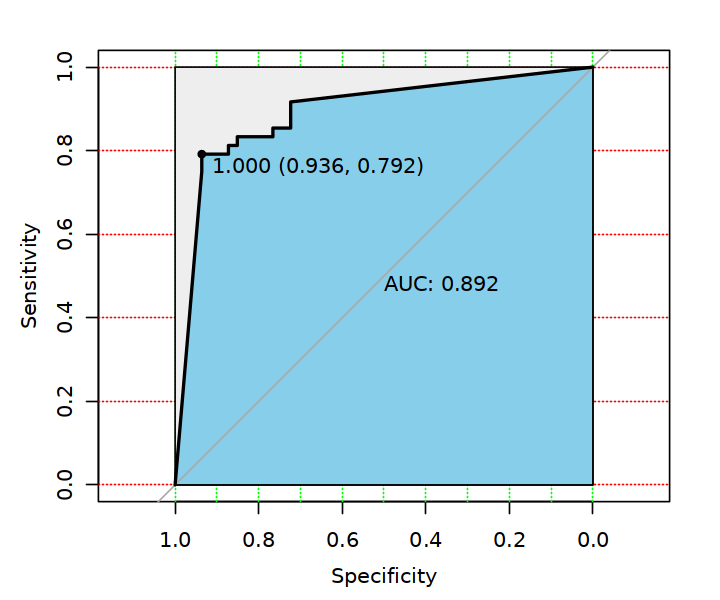

In [139]:
roc_curve <- pROC::roc(as.numeric(fold_test$Group),fold_predict)
plot(roc_curve, print.auc=TRUE, auc.polygon=TRUE, grid=c(0.1, 0.2),
     grid.col=c("green", "red"), max.auc.polygon=TRUE,
     auc.polygon.col="skyblue", print.thres=TRUE,main="")

In [140]:
library(ROCR)

dd<-datadist(data)  #开始打包数据
options(datadist="dd")

data$Group = as.factor(data$Group)

fit1 <- lrm(Group~TNFSF14+CCNA2+MARCKS+SGOL1+SAP130, data=data,x=T,y=T)


fit1

#  https://blog.csdn.net/Ayue0616/article/details/126601832

# cal1 <- calibrate(fit1, method='boot', B=1000) 
# plot(cal1,xlim=c(0,1.0),ylim=c(0,1.0))

### https://blog.51cto.com/u_15172991/5428282  模型图的解释参考链接

# https://ayueme.github.io/R_clinical_model/nomogram-essential.html

# https://blog.csdn.net/Dr_long1996/article/details/135446784

save(fit1,data,file = 'train.fit1.rda')

#列线图代码只能在Rstudio话

# library('regplot')
# regplot(fit1,
#         plots = c("violin", "boxes"), ##连续性变量形状，可选"no plot" "density" "boxes" "ecdf" "bars" "boxplot" "violin" "bean" "spikes"；分类变量的形状，可选"no plot" "boxes" "bars" "spikes"
#         observation = data[1,], #用哪行观测，或者T F
#         center = T, # 对齐变量
#         subticks = T,
#         droplines = T,#是否画竖线
#         title = "nomogram",
#         points = T, # 截距项显示为0-100
#         odds = T, # 是否显示OR值
#         showP = T, # 是否显示变量的显著性标记
#         rank = "sd", # 根据sd给变量排序
#         interval="confidence", # 展示可信区间
#         clickable = F # 是否可以交互
# )

Logistic Regression Model

lrm(formula = Group ~ TNFSF14 + CCNA2 + MARCKS + SGOL1 + SAP130, 
    data = data, x = T, y = T)

                       Model Likelihood     Discrimination    Rank Discrim.    
                             Ratio Test            Indexes          Indexes    
Obs           119    LR chi2      95.26     R2       0.735    C       0.946    
 1             59    d.f.             5     R2(5,119)0.532    Dxy     0.892    
 0             60    Pr(> chi2) <0.0001    R2(5,89.2)0.636    gamma   0.892    
max |deriv| 2e-09                           Brier    0.098    tau-a   0.450    

          Coef    S.E.   Wald Z Pr(>|Z|)
Intercept 23.5810 4.5806  5.15  <0.0001 
TNFSF14   -0.2377 0.0732 -3.25  0.0012  
CCNA2     -3.1092 0.8773 -3.54  0.0004  
MARCKS    -0.1434 0.0608 -2.36  0.0184  
SGOL1     -6.3197 2.0735 -3.05  0.0023  
SAP130    -0.6826 0.1766 -3.86  0.0001  


In [137]:
getwd()

[1] "/import/liujing/data/my"

In [ ]:
# library(rms)   ###加载rms包#
# #f = readRDS('C:/Users/Bonjour/Desktop/bulk2.fit1.rds')
# load('C:/Users/Bonjour/Desktop/train.fit1.rda')
# summary(fit1) 

# library('regplot')
# regplot(fit1,
#         plots = c("violin", "boxes"), ##连续性变量形状，可选"no plot" "density" "boxes" "ecdf" "bars" "boxplot" "violin" "bean" "spikes"；分类变量的形状，可选"no plot" "boxes" "bars" "spikes"
#         observation = data[1,], #用哪行观测，或者T F
#         center = F, # 对齐变量
#         subticks = F,
#         droplines = F,#是否画竖线
#         title = "nomogram",
#         points = T, # 截距项显示为0-100
#         odds = T, # 是否显示OR值
#         showP = T, # 是否显示变量的显著性标记
#         rank = "sd", # 根据sd给变量排序
#         interval="confidence", # 展示可信区间
#         clickable = F # 是否可以交互
# )
# fit1


In [94]:
fit.reduce <- glm(Group~TNFSF14+CCNA2+MARCKS+SGOL1+SAP130,data=data,family=binomial())

In [95]:
fit.result<-summary(fit.reduce)
df1<-fit.result$coefficients
df2<-confint(fit.reduce)
df3<-cbind(df1,df2)
df4<-data.frame(df3[-1,c(1,4,5,6)])
df4$Var<-rownames(df4)
colnames(df4)<-c("OR","Pvalue","OR_1","OR_2","Var")
df5<-df4[,c(5,1,2,3,4)]
df5$OR_mean<-df5$OR
df5$OR<-paste0(round(df5$OR,2),
               "(",
               round(df5$OR_1,2),
               "~",
               round(df5$OR_2,2),
               ")")
df5$Pvalue<-round(df5$Pvalue,3)
write.csv(df5,file = "forestplot_example.csv",
          quote = F,row.names = F)


Waiting for profiling to be done...

Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted probabilities numerically 0 or 1 occurred"
Warning message:
"glm.fit: fitted proba

In [96]:
df5

,Var,OR,Pvalue,OR_1,OR_2,OR_mean
,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
TNFSF14,TNFSF14,-0.24(-0.4~-0.11),0.001,-0.3984643,-0.10646039,-0.2376950
CCNA2,CCNA2,-3.11(-5.03~-1.54),0.000,-5.0303016,-1.54327199,-3.1092182
MARCKS,MARCKS,-0.14(-0.28~-0.03),0.018,-0.2757006,-0.03433449,-0.1433905
SGOL1,SGOL1,-6.32(-10.69~-2.45),0.002,-10.6908772,-2.45313728,-6.3197097
SAP130,SAP130,-0.68(-1.07~-0.37),0.000,-1.0714897,-0.36875580,-0.6825936


In [97]:

# library(forestplot)
# fp<-read.csv("forestplot_example.csv",header=T)

# forestplot(labeltext=as.matrix(fp[,1:3]),
#            mean=fp$OR_mean,
#            lower=fp$OR_1,
#            upper=fp$OR_2,
#            zero=1,
#            boxsize=0.2,
#            graph.pos=2)

In [98]:
library("autoReg")


Attaching package: 'autoReg'


The following object is masked from 'package:MASS':

    select




In [99]:
dim(data)

[1] 119  18

In [100]:
table(data$Group)


 1  0 
59 60 

In [101]:
overall.log =  glm(Group~TNFSF14+CCNA2+MARCKS+SGOL1+SAP130,data=data,family=binomial())

model3<-autoReg(overall.log,uni=TRUE,milti=TRUE,threshold=0.05)

model3

name,desc,1 (N=59),0 (N=60),id,OR (univariable),OR (multivariable)
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
TNFSF14,Mean <U+00B1> SD,24.4 <U+00B1> 6.8,19.4 <U+00B1> 3.7,TNFSF14,"0.84 (0.77-0.91, p<.001)","0.79 (0.68-0.91, p=.001)"
CCNA2,Mean <U+00B1> SD,1.7 <U+00B1> 1.2,1.1 <U+00B1> 0.4,CCNA2,"0.17 (0.07-0.42, p<.001)","0.04 (0.01-0.25, p<.001)"
MARCKS,Mean <U+00B1> SD,22.1 <U+00B1> 7.0,17.3 <U+00B1> 5.5,MARCKS,"0.88 (0.83-0.94, p<.001)","0.87 (0.77-0.98, p=.018)"
SGOL1,Mean <U+00B1> SD,0.5 <U+00B1> 0.2,0.4 <U+00B1> 0.2,SGOL1,"0.04 (0.00-0.36, p=.004)","0.00 (0.00-0.10, p=.002)"
SAP130,Mean <U+00B1> SD,14.5 <U+00B1> 2.8,12.0 <U+00B1> 1.7,SAP130,"0.55 (0.43-0.70, p<.001)","0.51 (0.36-0.71, p<.001)"


In [102]:
overall.log =  glm(Group~TNFSF14+CCNA2+MARCKS+SGOL1+SAP130,data=fold_test,family=binomial())

model3<-autoReg(overall.log,uni=TRUE,milti=TRUE,threshold=0.05)

model3

name,desc,1 (N=47),0 (N=48),id,OR (univariable),OR (multivariable)
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
TNFSF14,Mean <U+00B1> SD,24.3 <U+00B1> 7.2,19.1 <U+00B1> 3.9,TNFSF14,"0.85 (0.78-0.93, p<.001)","0.80 (0.69-0.92, p=.002)"
CCNA2,Mean <U+00B1> SD,1.7 <U+00B1> 1.3,1.1 <U+00B1> 0.4,CCNA2,"0.25 (0.09-0.66, p=.005)","0.08 (0.01-0.43, p=.004)"
MARCKS,Mean <U+00B1> SD,22.1 <U+00B1> 7.2,17.4 <U+00B1> 5.6,MARCKS,"0.89 (0.83-0.96, p=.002)","0.88 (0.79-1.00, p=.043)"
SGOL1,Mean <U+00B1> SD,0.5 <U+00B1> 0.2,0.4 <U+00B1> 0.1,SGOL1,"0.06 (0.01-0.65, p=.021)","0.00 (0.00-0.17, p=.006)"
SAP130,Mean <U+00B1> SD,14.2 <U+00B1> 2.5,11.9 <U+00B1> 1.8,SAP130,"0.58 (0.45-0.75, p<.001)","0.53 (0.38-0.75, p<.001)"


In [103]:
# https://blog.csdn.net/m0_72224305/article/details/126825816

In [104]:
# https://www.mebis.cn/kexuexinwen/1035.html  解释了保护因子和危险因子的含义

In [105]:
options(repr.plot.width = 8)

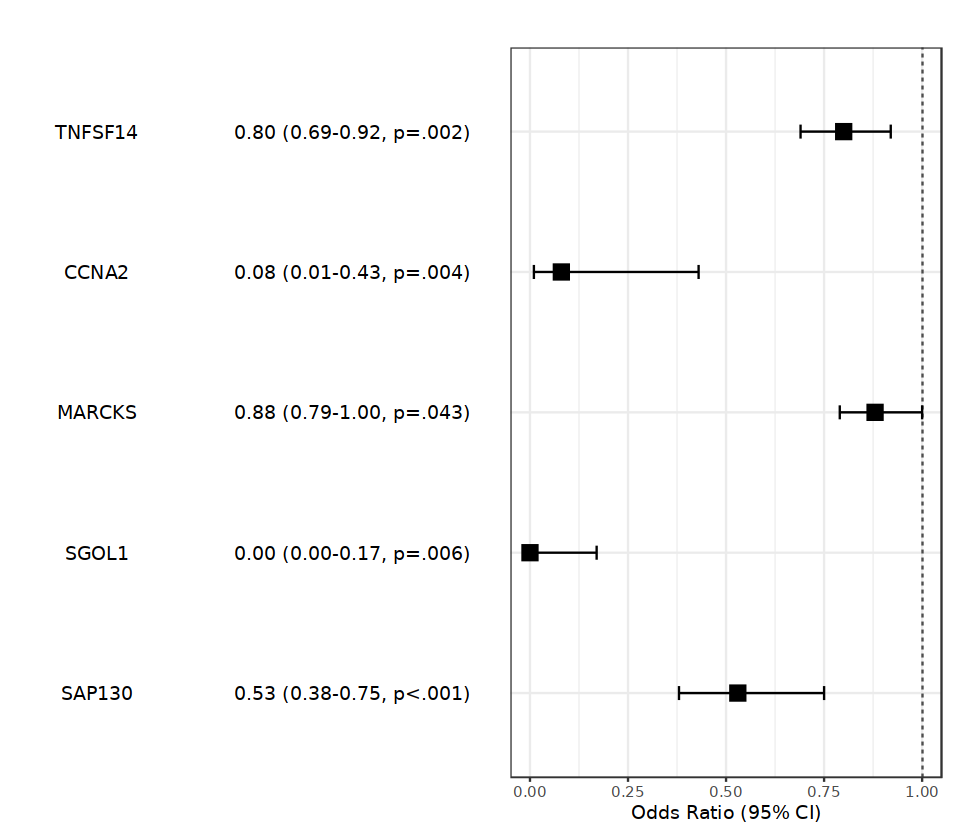

In [106]:
modelPlot(overall.log,change.pointsize = T)

In [107]:
tend = expr3

In [108]:
tend$Group = ifelse(tend$Group == 1, 'CI','H')

In [109]:
model.gene

[1] "RAB7A"     "CMTM1"     "PLP2"      "RPL28"     "OTX1"      "NEK2"     
 [7] "TNFSF14"   "SGOL1"     "SP110"     "SAP130"    "CEP55"     "TPM3"     
[13] "CCNA2"     "MARCKS"    "U2AF1L4"   "S100A11"   "ZNF608"    "RRM2"     
[19] "HIST2H2BE" "TLR5"

In [110]:
model.gene = c('TNFSF14','CCNA2','MARCKS','SGOL1','SAP130')

In [111]:
tend = tend[,c('Group',model.gene)]

In [112]:
head(tend,2)

,Group,TNFSF14,CCNA2,MARCKS,SGOL1,SAP130
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CI10_M1,CI,12.33071,1.3665421,13.45120,0.9586298,11.27051
CI11_M1,CI,26.09770,0.8565347,22.73914,0.4597942,13.74484


In [113]:
require(cowplot)
require(tidyverse)
require(ggplot2)
require(ggsci)
require(ggpubr)

Loading required package: cowplot

Warning message:
"package 'cowplot' was built under R version 4.2.3"
Loading required package: ggsci

Warning message:
"package 'ggsci' was built under R version 4.2.3"
Loading required package: ggpubr

Warning message:
"package 'ggpubr' was built under R version 4.2.3"

Attaching package: 'ggpubr'


The following object is masked from 'package:cowplot':

    get_legend


The following object is masked from 'package:plyr':

    mutate


The following object is masked from 'package:VennDiagram':

    rotate




In [114]:
mydata<-tend %>% 
  ## 基因表达数据gather,gather的范围应调整
  gather(key="gene",value="Expression",TNFSF14:SAP130) %>% 
  ##
  dplyr::select(Group,gene,Expression) 

In [115]:
compare_means( Expression ~ Group, data = mydata, method = 't.test',
              group.by = "gene")
# Box plot facetted by "gene"
p <- ggboxplot(mydata, x = "Group", y = "Expression",
          color = "Group", palette = "jco",
          add = "jitter",
          facet.by = "gene", short.panel.labs = FALSE)
# Use only p.format as label. Remove method name.
#p + stat_compare_means(label =  "p.signif", label.x = 1.5)
p <- ggboxplot(mydata, x = "gene", y = "Expression",
          color = "Group", palette = "nejm",
          add = "jitter")

gene,.y.,group1,group2,p,p.adj,p.format,p.signif,method
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>
TNFSF14,Expression,CI,H,4.057186e-06,1.6e-05,4.1e-06,****,T-test
CCNA2,Expression,CI,H,9.307185e-05,2.2e-04,9.3e-05,****,T-test
MARCKS,Expression,CI,H,7.311824e-05,2.2e-04,7.3e-05,****,T-test
SGOL1,Expression,CI,H,2.097678e-03,2.1e-03,0.0021,**,T-test
SAP130,Expression,CI,H,3.233072e-08,1.6e-07,3.2e-08,****,T-test


In [116]:
diffgene = as.data.frame(compare_means( Expression ~ Group, data = mydata, method = 't.test',
              group.by = "gene"))

In [ ]:
diffgene = rownames(diffgene) = diffgene[,1]

options(repr.plot.height = 5,repr.plot.width = 21)

options(repr.plot.width = 7,repr.plot.height = 5)

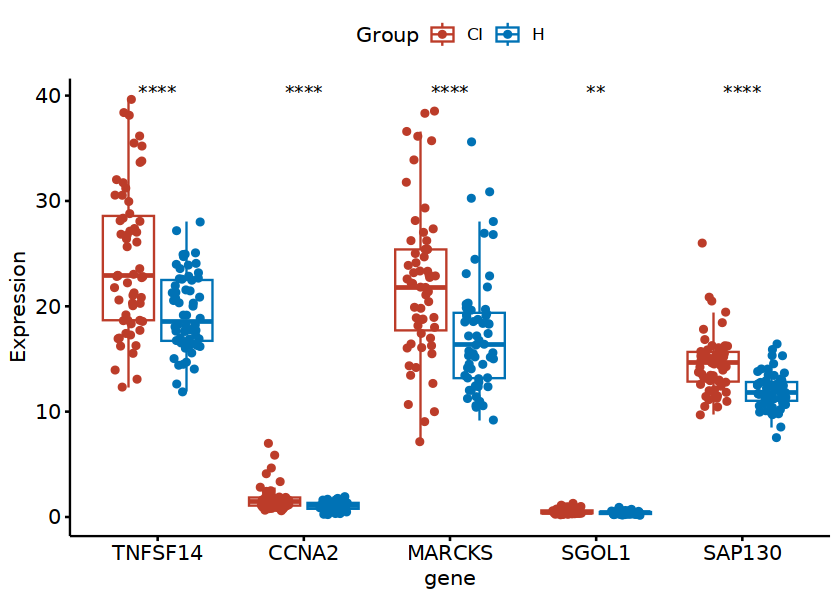

In [120]:
p + stat_compare_means(aes(group = Group), label = "p.signif",method = 't.test')

In [121]:
tend1 = tend[,c( 2:6)] 

In [122]:
gene_cor <- cor(tend1, method = 'pearson')

In [123]:
diag(gene_cor) <- 0
gene_cor <- reshape2::melt(gene_cor)
gene_cor <- subset(gene_cor, value != 0)  #去除0值的相关性
head(gene_cor)

,Var1,Var2,value
,<fct>,<fct>,<dbl>
2,CCNA2,TNFSF14,-0.06566354
3,MARCKS,TNFSF14,0.44125543
4,SGOL1,TNFSF14,-0.19477187
5,SAP130,TNFSF14,0.29641398
6,TNFSF14,CCNA2,-0.06566354
8,MARCKS,CCNA2,0.05135958


In [124]:
library(circlize)
pdf('cor.circle.pdf',height = 6,width = 6)
p= chordDiagram(gene_cor, 
    annotationTrack = c('grid', 'name', 'axis'), #绘制外周圆弧区，显示名称和刻度轴
    grid.col = c(TNFSF14 = 'green3', CCNA2 = 'red', MARCKS = 'orange', SGOL1 = 'purple', SAP130 = 'skyblue'), #定义基因颜色
    col = colorRamp2(c(-1, 0, 1), c('green', 'white', 'red'), transparency = 0.5), #根据相关性大小展示连线的颜色范围
    annotationTrackHeight = c(0.05, 0.05), #名称离圆弧的距离，以及圆弧的宽度
)
dev.off()

circlize version 0.4.16
CRAN page: https://cran.r-project.org/package=circlize
Github page: https://github.com/jokergoo/circlize
Documentation: https://jokergoo.github.io/circlize_book/book/

If you use it in published research, please cite:
Gu, Z. circlize implements and enhances circular visualization
  in R. Bioinformatics 2014.

This message can be suppressed by:
  suppressPackageStartupMessages(library(circlize))




png 
  2

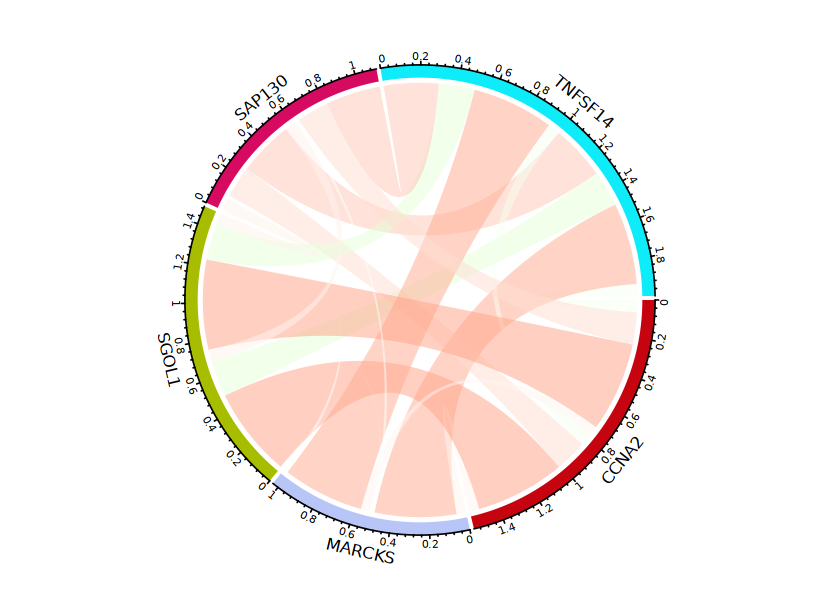

In [125]:
chordDiagram(gene_cor, 
    annotationTrack = c('grid', 'name', 'axis'), #绘制外周圆弧区，显示名称和刻度轴
    #grid.col = c(GABRD = 'green3', PLVAP = 'red', CDKN3 = 'orange', CDC25C = 'purple', UBE2T = 'skyblue', SKA1 = 'blue'), #定义基因颜色
    col = colorRamp2(c(-1, 0, 1), c('green', 'white', 'red'), transparency = 0.5), #根据相关性大小展示连线的颜色范围
    annotationTrackHeight = c(0.05, 0.05), )#名称离圆弧的距离，以及圆弧的宽度

In [129]:
save(data,file = 'data.rda')

In [130]:
library(autoReg)

In [131]:
logreg4<-autoReg(fit.reduce,uni=TRUE,threshold=0.05, final=T)   #final=T逐步回归
logreg4
logtable4<-myft(logreg4)

name,desc,1 (N=59),0 (N=60),id,OR (univariable),OR (multivariable),OR (final)
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
TNFSF14,Mean <U+00B1> SD,24.4 <U+00B1> 6.8,19.4 <U+00B1> 3.7,TNFSF14,"0.84 (0.77-0.91, p<.001)","0.79 (0.68-0.91, p=.001)","0.79 (0.68-0.91, p=.001)"
CCNA2,Mean <U+00B1> SD,1.7 <U+00B1> 1.2,1.1 <U+00B1> 0.4,CCNA2,"0.17 (0.07-0.42, p<.001)","0.04 (0.01-0.25, p<.001)","0.04 (0.01-0.25, p<.001)"
MARCKS,Mean <U+00B1> SD,22.1 <U+00B1> 7.0,17.3 <U+00B1> 5.5,MARCKS,"0.88 (0.83-0.94, p<.001)","0.87 (0.77-0.98, p=.018)","0.87 (0.77-0.98, p=.018)"
SGOL1,Mean <U+00B1> SD,0.5 <U+00B1> 0.2,0.4 <U+00B1> 0.2,SGOL1,"0.04 (0.00-0.36, p=.004)","0.00 (0.00-0.10, p=.002)","0.00 (0.00-0.10, p=.002)"
SAP130,Mean <U+00B1> SD,14.5 <U+00B1> 2.8,12.0 <U+00B1> 1.7,SAP130,"0.55 (0.43-0.70, p<.001)","0.51 (0.36-0.71, p<.001)","0.51 (0.36-0.71, p<.001)"
